<a href="https://colab.research.google.com/github/yeyevtushenko/AnalysisBMD_YevtusenkoBS-25/blob/main/%D0%9E%D0%B1%D1%80%D0%BE%D0%B1%D0%BA%D0%B0_%D1%82%D0%B0_%D0%B0%D0%BD%D0%B0%D0%BB%D1%96%D0%B7_%D0%B1%D1%96%D0%BE%D0%BC%D0%B5%D0%B4%D0%B8%D1%87%D0%BD%D0%B8%D1%85_%D0%B4%D0%B0%D0%BD%D0%B8%D1%85_%D0%91%D0%A1_25_%D0%90%D0%BB%D1%8C_%D0%A5%D0%BC%D1%83%D0%B7_%D0%84%D0%B2%D1%82%D1%83%D1%88%D0%B5%D0%BD%D0%BA%D0%BE_%D0%A0%D0%A0_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Розрахункова робота

## Імпорт основних модулів



Для роботи з даними

In [1]:
import numpy as np
import pandas as pd

Для візуалізації даних

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Для проведення тестів

In [3]:
from scipy import stats

Для лінійної регресії

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn import metrics

Для класифікації

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

## Завантаження даних

Дані датасету:
* id -- Унікальний ідентифікатор кожного пацієнта
* age -- Вік пацієнта в роках
* dataset -- джерело даних
* sex -- Чоловік/Жінка
* cp chest pain type -- typical angina, atypical angina, non-anginal, asymptomatic/типова стенокардія, нетипова стенокардія, не стенокардичний, асимптоматичний
* trestbps -- артеріальний тиск у спокої (артеріальний тиск у спокої (у мм рт. ст. при прийомі до лікарні))
* chol -- холестерин сироватки крові в мг/дл
* fbs -- якщо рівень цукру в крові натщесерце > 120 мг/дл
* restecg -- результати рестингової електрокардіограми

Values: [normal, stt abnormality, lv hypertrophy]
* thalch -- максимальна досягнута частота серцебиття
* exang -- стенокардія, викликана вправами (Так/Ні)
* oldpeak -- ST-депресія, викликана вправами відносно спокою
* slope -- нахил пікового сегмента ST під час вправ
* ca -- кількість великих судин (0-3), забарвлених за допомогою флюороскопії
* thal -- [normal; fixed defect; reversible defect]
* num -- хвороба серця від 0 до 4 (0=немає хвороби серця; 1,2,3,4 = стадії хвороби серця)

In [6]:
heart = pd.read_csv("https://raw.githubusercontent.com/yeyevtushenko/AnalysisBMD_YevtusenkoBS-25/Data/heart_disease_uci.csv")

In [7]:
heart.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Видалимо колонку Id, так як вона не несе ніякого змісту

In [8]:
heart.drop("id", axis=1, inplace=True)

Також в датасеті не дуже зрозуміло зміст колонки num тому змінимо її назву на heart disease а значення переведемо наступним чином:
0=немає хвороби серця; 1,2,3,4 = стадії хвороби серця
- 0 - no heart disease
- 1 - mild heart disease
- 2 - moderate heart disease
- 3 - severe heart disease
- 4 - critical heart disease

In [9]:
no_heart_disease = 0
mild_heart_disease = 1
moderate_heart_disease = 2
severe_heart_disease = 3
critical_heart_disease = 4

# Тут ми створюємо нову колонку вже з категоріальною змінною
heart["disease"] = heart["num"].apply(
    lambda x: "no heart disease" if x == no_heart_disease else (
        "mild heart disease" if x == mild_heart_disease else (
            "moderate heart disease" if x == moderate_heart_disease else (
                "severe heart disease" if x == severe_heart_disease else "critical heart disease"
            )
        )
    )
)

In [10]:
heart.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num,disease
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0,no heart disease
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2,moderate heart disease
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1,mild heart disease
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0,no heart disease
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0,no heart disease


##Описові характеристики


Описові характеристики (або описова статистика) це методи статистичного аналізу, які дозволяють коротко описати або підсумувати великий набір даних. Ці характеристики використовуються для того, щоб мати загальне уявлення про дані, з якими ми працюємо, і часто виводять наступні показники:


1. Середнє (Mean): Сума всіх значень у наборі даних, поділена на кількість цих значень. Середнє використовується для визначення центральної тенденції даних.
2. Медіана (Median/50%): Середнє значення у впорядкованому списку даних. Медіана є кращим показником центральної тенденції, коли дані мають великі викиди.
3. Стандартне відхилення (Standard Deviation): Квадратний корінь з середньоквадратичного відхилення від середнього. Стандартне відхилення використовується для визначення розкиду даних від середнього.
4. Квартилі (Quartiles): Значення, які ділять ваш набір даних на чотири рівних частини. Найбільш відомими є перший квартиль (25%), медіана (50%), та третій квартиль (75%).
5. Мінімум і Максимум (Min and Max): Найнижче і найвище або найменше і найбільше значення в наборі даних.





In [17]:
heart.describe()

,age,trestbps,chol,thalch,oldpeak,ca,num
count,920.000000,920.000000,920.000000,920.000000,920.000000,920.00000,920.000000
mean,53.510870,129.700000,202.122826,137.600000,0.905435,0.91413,0.995652
std,9.424685,25.169614,113.889047,26.809545,1.211063,0.86914,1.142693
min,28.000000,0.000000,0.000000,60.000000,-2.600000,0.00000,0.000000
25%,47.000000,120.000000,175.000000,120.000000,0.000000,0.00000,0.000000
50%,54.000000,130.000000,224.000000,140.000000,0.500000,1.00000,1.000000
75%,60.000000,140.000000,270.000000,158.000000,1.600000,2.00000,2.000000
max,77.000000,200.000000,603.000000,202.000000,6.200000,3.00000,4.000000


##Графіки для декількох змінних

In [19]:
heart.columns

Index(['age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
       'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num', 'disease'],
      dtype='object')

Text(0.5, 1.0, 'Ящикова діаграма віку')

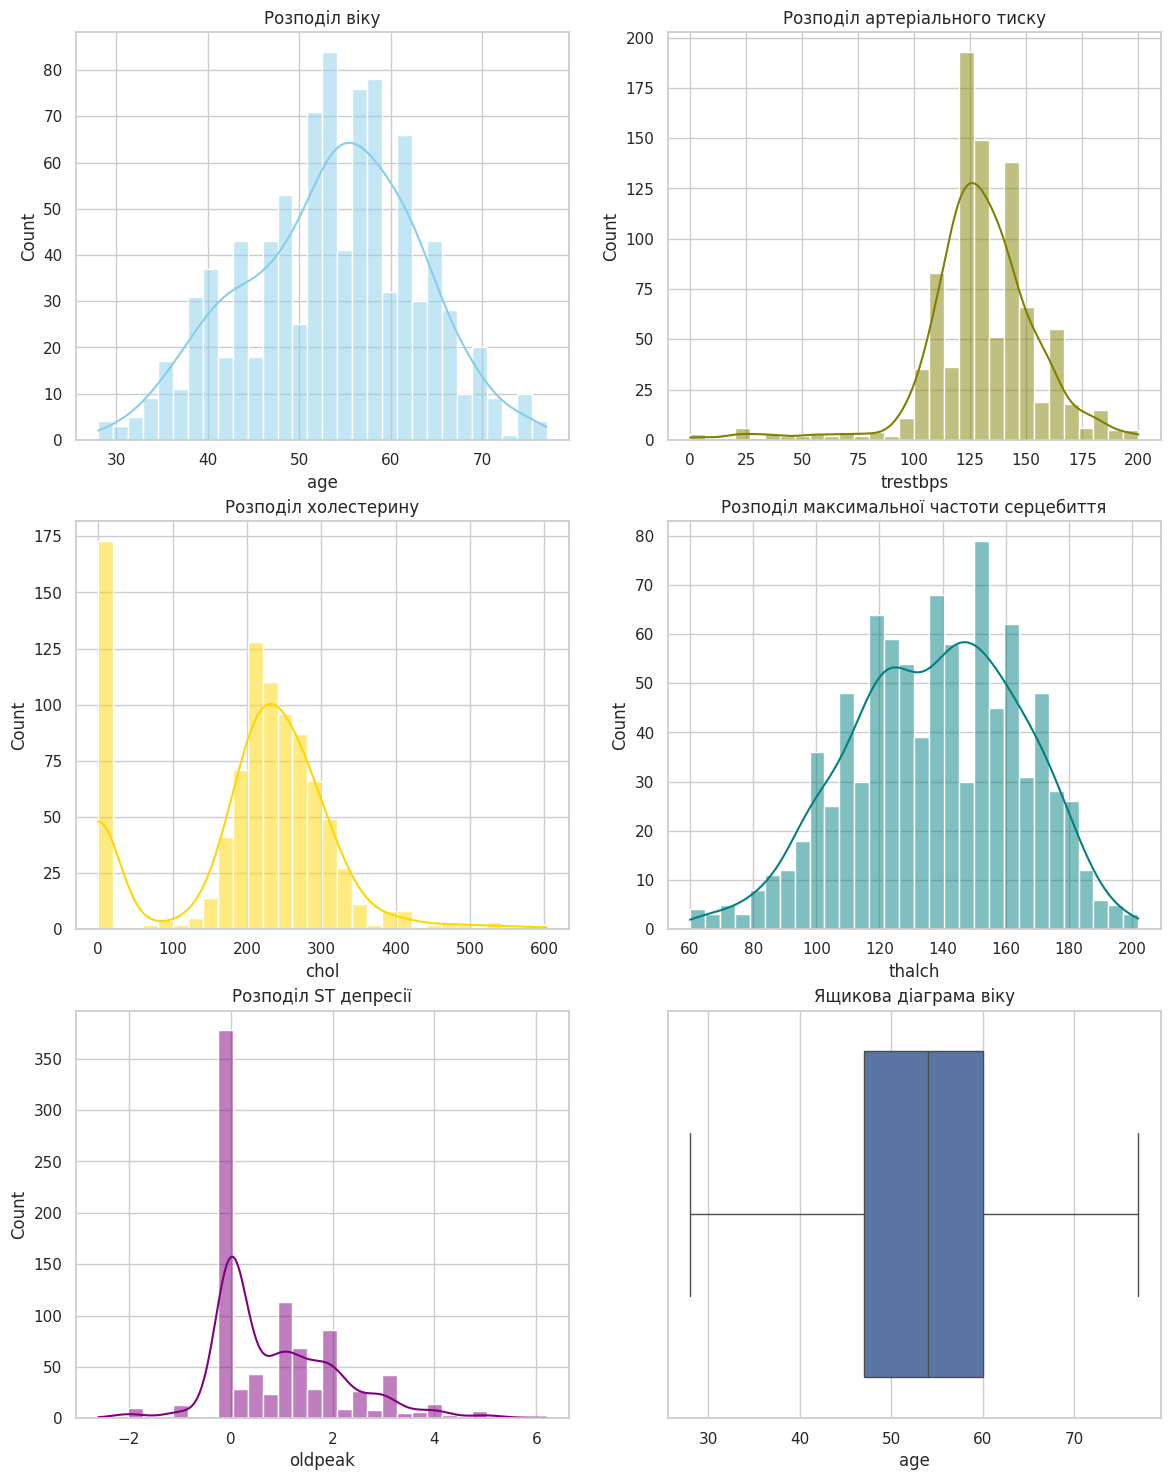

In [20]:
sns.set(style="whitegrid")

fig, axes = plt.subplots(3, 2, figsize=(14, 18))

sns.histplot(data=heart, x='age', bins=30, kde=True, ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Розподіл віку')

sns.histplot(data=heart, x='trestbps', bins=30, kde=True, ax=axes[0, 1], color='olive')
axes[0, 1].set_title('Розподіл артеріального тиску')

sns.histplot(data=heart, x='chol', bins=30, kde=True, ax=axes[1, 0], color='gold')
axes[1, 0].set_title('Розподіл холестерину')

sns.histplot(data=heart, x='thalch', bins=30, kde=True, ax=axes[1, 1], color='teal')
axes[1, 1].set_title('Розподіл максимальної частоти серцебиття')

sns.histplot(data=heart, x='oldpeak', bins=30, kde=True, ax=axes[2, 0], color='purple')
axes[2, 0].set_title('Розподіл ST депресії')

sns.boxplot(data=heart, x='age', ax=axes[2, 1])
axes[2, 1].set_title('Ящикова діаграма віку')

### Матриця кореляції

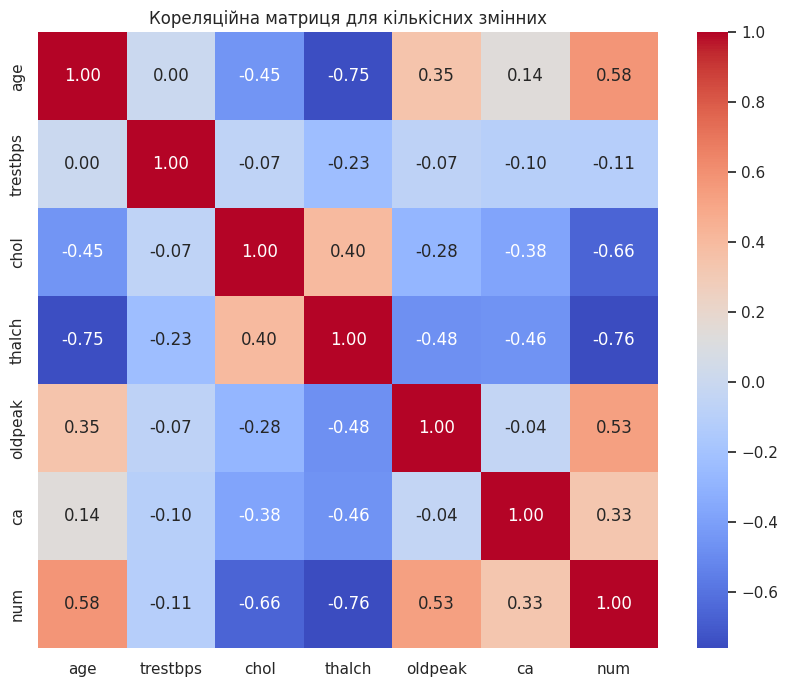

In [28]:
plt.figure(figsize=(10, 8))
sns.heatmap(heart.select_dtypes(include='number').corr().corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Кореляційна матриця для кількісних змінних")
plt.show()

 ### Pairplot

Pairplot це  дуже корисний інструмент, що надає змогу швидко візуалізувати взаємозв'язки між кількома змінними в одному датасеті. Основна мета цього інструменту перевірити, як змінні взаємодіють між собою, допомогти виявити структуру, взаємозв'язки, аномалії, зразки і потенційні гіпотези для подальшого детальнішого аналізу.

На діагоналі pairplot зазвичай розміщені гістограми або щільності розподілу кожної змінної. Це дає нам загальне уявлення про розподіл кожної змінної, включно з її формою, піками та розкидом.

Всі графіки поза діагоналлю є скаттерплотами, які показують взаємозв'язки між парами змінних. Це дозволяє оцінити, чи є між змінними лінійні зв'язки, чи існують патерни або групування, а також виявити можливі викиди в даних.

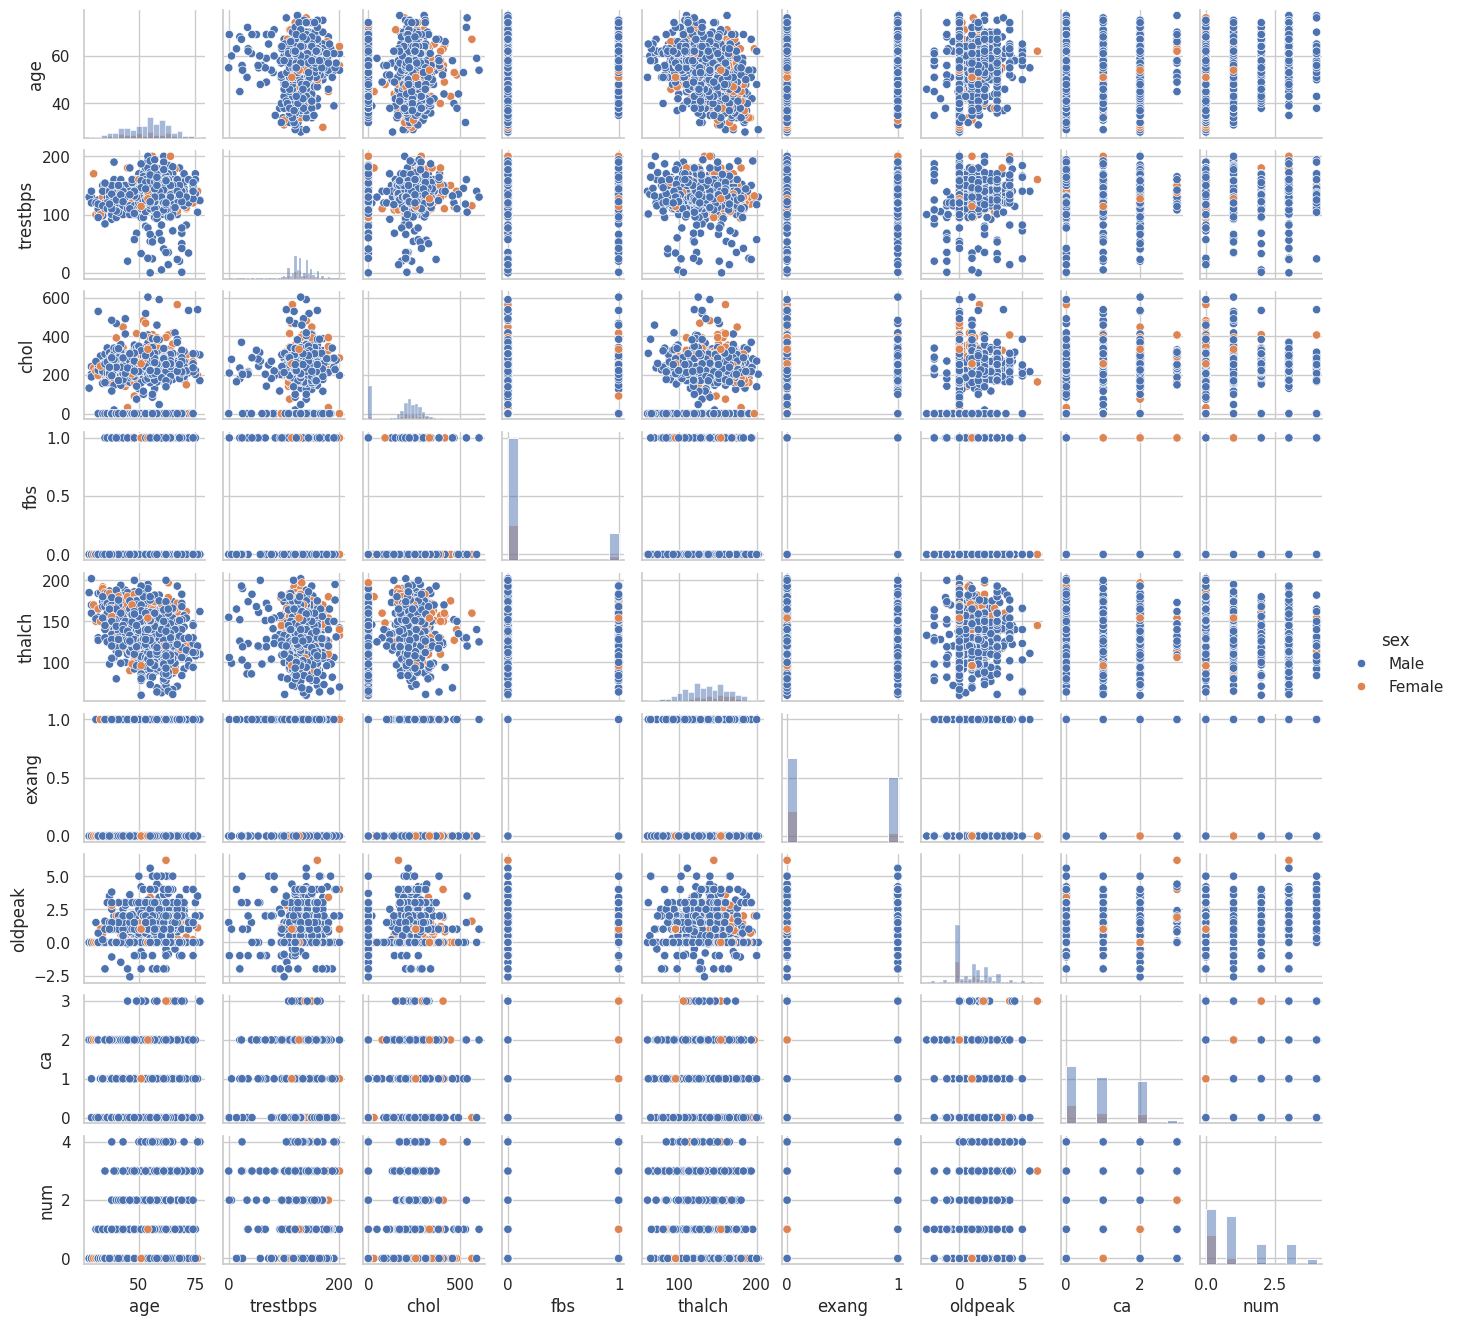

In [32]:
sns.pairplot(heart,
             hue="sex",
             diag_kind="hist",
             height=1.5)
plt.show()

На основі нашого Pairplot можемо зробити кілька цінних спостережень і висновків:
- Розподіл віку здається досить рівномірним, хоча є злегка право-скішеність. Це вказує на те, що вибірка має більше старших індивідів.
- Більшість значень артеріальний тиску зосереджені в межах від 120 до 140 мм рт.ст., але є деякі викиди, що свідчать про високий артеріальний тиск у деяких індивідів.
- Розподіл холестерину показує значну кількість високих значень, що може бути фактором ризику серцевих захворювань.
- Існує слабкий взаємозв'язок між віком і артеріальним тиском, що свідчить, що артеріальний тиск може злегка збільшуватися з віком.
- Видно слабкий зв'язок між зростанням холестерину і віком, що також є логічним, оскільки старші люди частіше мають вищі рівні холестерину.
- Парні графіки показують, що серед мужчин і жінок розподіл багатьох медичних індикаторів виглядає подібно, але є відмінності в деяких аспектах, наприклад у рівнях холестерину.
- Цікаво відзначити, що високі значення num (що вказують на більш серйозні стадії серцевих захворювань) мають тенденцію асоціюватися з вищими значеннями oldpeak та вищим артеріальним тиском.

## Перевірка на нормальність

In [35]:
heart.shape

(920, 16)

In [43]:
from scipy.stats import shapiro
for column_name in heart.select_dtypes(include="number").columns:
    stat, p = shapiro(heart[column_name])
    print(f'Стовпець: {column_name}')
    print(f'Статистика: {stat:.3f}, p-значення: {p:.3g}')

    alpha = 0.03
    if p > alpha:
        print('Розподіл вважається нормальним (не відкидаємо H0)')
    else:
        print('Розподіл не є нормальним (відкидаємо H0)')

Стовпець: age
Статистика: 0.994, p-значення: 0.0154
Розподіл не є нормальним (відкидаємо H0)
Стовпець: trestbps
Статистика: 0.978, p-значення: 7.54e-08
Розподіл не є нормальним (відкидаємо H0)
Стовпець: chol
Статистика: 0.989, p-значення: 0.00021
Розподіл не є нормальним (відкидаємо H0)
Стовпець: thalch
Статистика: 0.986, p-значення: 1.22e-05
Розподіл не є нормальним (відкидаємо H0)
Стовпець: oldpeak
Статистика: 0.809, p-значення: 5.71e-26
Розподіл не є нормальним (відкидаємо H0)
Стовпець: ca
Статистика: 0.793, p-значення: 6.94e-27
Розподіл не є нормальним (відкидаємо H0)
Стовпець: num
Статистика: 0.698, p-значення: 2.45e-31
Розподіл не є нормальним (відкидаємо H0)


## Перевірка гіпотез та висновки

Після перевірки даних на нормальність розподілу можемо перейти до генерації гіпотез та перевірку їх непараметричними тестами, чому непараметричними, бо колькісні дані не відповідають нормальному розподілу



1. Чи є різниця в середньому артеріальному тиску між чоловіками та жінками?
2. Чи впливає наявність діабету (fbs > 120 mg/dl) на рівень холестерину?
3. Чи є відмінності в максимальній частоті серцебиття між пацієнтами з різними типами болю в грудях?
4. Чи впливає вік на рівень холестерину?
5. Чи залежить середня ST депресія від наявності серцевого захворювання?
6. Чи є відмінності в артеріальному тиску між пацієнтами з різним ступенем серцевого захворювання?
7. Чи впливає стать на рівень максимальної частоти серцебиття?
8. Чи є різниця в середньому віці між пацієнтами з та без вправного-індукованого стенокардії?
9. Чи залежить кількість великих судин, забарвлених флюороскопією, від стадії серцевого захворювання?
10. Чи відрізняється рівень холестерину між пацієнтами з різними результатами електрокардіограми під час спокою?
11. Чи є відмінності в середньому віці між групами з різним рівнем ST депресії?
12. Чи впливає стать на кількість забарвлених флюороскопією судин?
13. Чи залежить наявність стенокардії від віку?
14. Чи відрізняється кількість судин (ca) у пацієнтів з фіксованим та оборотним дефектом по thal?
15. Чи є різниця в рівнях trestbps між тими, хто досяг максимальної частоти серцебиття, та тими, хто не досяг?
16. Чи є зв'язок між типом болю в грудях та наявністю серцевого захворювання?
17. Чи впливає стать на середню ST депресію?
18. Чи залежить тип thal від віку?
19. Чи відрізняються рівні chol у пацієнтів з та без індукованої вправами стенокардії?
20. Чи є різниця в середньому віці між пацієнтами з різними типами thal?

In [65]:
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal
from scipy.stats import spearmanr

Для всіх гіпотез будемо дотримуватись загальноприйнятого правила. Якщо p > 0.05 дотримуємось нульової гіпотези, якщо < - альтернативна гіпотеза

### 1 Гіпотеза


Нульова гіпотеза (H0): Середній артеріальний тиск (trestbps) чоловіків дорівнює середньому артеріальному тиску жінок. Іншими словами, стать не впливає на артеріальний тиск.

Альтернативна гіпотеза (H1): Середній артеріальний тиск чоловіків відрізняється від середнього артеріального тиску жінок.

In [45]:
# Виділення груп
male_bp = heart[heart['sex'] == 'Male']['trestbps']
female_bp = heart[heart['sex'] == 'Female']['trestbps']

# Виконання Манна-Уітні тесту
stat, p_value = mannwhitneyu(male_bp, female_bp)

# Виведення результатів
print("U-статистика:", stat)
print("p-значення:", p_value)

U-статистика: 38185.5
p-значення: 0.10654465753221166


#### **Висновок**

p-значення, яке ми отримали, становить 0.1065, що є більшим за звичайний поріг значущості 0.05. Це означає, що ми не маємо достатніх статистичних доказів для того, щоб відкинути нульову гіпотезу. Згідно з нашим аналізом, немає значущої різниці в середньому артеріальному тиску між чоловіками та жінками.

### 2 Гіпотеза

Нульова гіпотеза (H0): Наявність діабету (означена як підвищений рівень глюкози в крові, fbs > 120 mg/dl) не впливає на рівень холестерину.

Альтернативна гіпотеза (H1): Існує статистично значущий вплив наявності діабету на рівень холестерину.

In [46]:
# Виділення груп
diabetes_chol = heart[heart['fbs'] > 0.5]['chol']
no_diabetes_chol = heart[heart['fbs'] <= 0.5]['chol']

# Виконання Манна-Уітні тесту
stat, p_value = mannwhitneyu(diabetes_chol, no_diabetes_chol)

# Виведення результатів
print("U-статистика:", stat)
print("p-значення:", p_value)

U-статистика: 21693.5
p-значення: 0.9429797088836087


#### Висновок

Отримане p-значення складає 0.9429, що значно перевищує загальноприйнятий поріг значущості (0.05). Це означає, що ми не маємо достатніх статистичних підстав для відкидання нульової гіпотези. Згідно з результатами тесту, немає статистично значущої різниці в рівнях холестерину між особами з діабетом і без діабету.



### 3 Гіпотеза

Нульова гіпотеза (H0): Максимальна частота серцебиття (thalach) не відрізняється між пацієнтами з "atypical angina" і "asymptomatic".

Альтернативна гіпотеза (H1): Існують статистично значущі відмінності у максимальній частоті серцебиття між пацієнтами з "atypical angina" та "asymptomatic".

In [63]:
# Виконання Критерію Крускала-Валліса
stat, p_value = kruskal(heart[heart['cp'] == 'atypical angina']['thalch'], heart[heart['cp'] == 'asymptomatic']['thalch'] )

# Виведення результатів
print("H-статистика:", stat)
print("p-значення:", p_value)

H-статистика: 66.32119221289325
p-значення: 3.831173913023417e-16


#### Висновок

Отримане p-значення є дуже малим, значно меншим за загальноприйнятий поріг значущості
0.05. Це означає, що ми маємо дуже сильні статистичні докази для відкидання нульової гіпотези. Згідно з нашим аналізом, існує статистично значуща різниця в максимальній частоті серцебиття між пацієнтами з "atypical angina" та тими, хто "asymptomatic".

### 4 Гіпотеза

Нульова гіпотеза (H0): Вік не впливає на рівень холестерину (chol).

Альтернативна гіпотеза (H1): Існує статистично значущий вплив віку на рівень холестерину.

In [66]:
corr, p_value = spearmanr(heart['age'], heart['chol'])

# Виведення результатів
print("Кореляція Спірмена:", corr)
print("p-значення:", p_value)

Кореляція Спірмена: 0.10750688251923335
p-значення: 0.008510747219340265


#### Висновок

Отримане p-значення становить 0.00851, що є меншим за загальноприйнятий поріг значущості (0.05). Це означає, що ми маємо статистичні підстави відкинути нульову гіпотезу. З цих результатів можна зробити висновок, що існує статистично значуща, хоч і слабка, позитивна кореляція між віком особи і її рівнем холестерину.

### 5 Гіпотеза

Нульова гіпотеза (H0): Наявність серцевого захворювання не впливає на середню ST депресію (oldpeak).

Альтернативна гіпотеза (H1): Є статистично значущий вплив наявності серцевого захворювання на середню ST депресію (oldpeak).



In [67]:
# Визначення груп за наявністю серцевого захворювання
group_no_disease = heart[heart['num'] == 0]['oldpeak']  # Припускаємо, що 'num' == 0 це без серцевого захворювання
group_disease = heart[heart['num'] != 0]['oldpeak']  # Припускаємо, що 'num' != 0 це з серцевим захворюванням

# Виконання Критерію Крускала-Валліса
stat, p_value = kruskal(group_no_disease, group_disease)

# Виведення результатів
print("H-статистика:", stat)
print("p-значення:", p_value)

H-статистика: 100.90037196492321
p-значення: 9.672837084933735e-24


#### Висновок

Отримане p-значення є надзвичайно малим, значно меншим за загальноприйнятий поріг значущості (0.05). Це означає, що ми маємо дуже сильні статистичні докази для відкидання нульової гіпотези. З цих результатів можна зробити висновок, що існує статистично значуща різниця в середній ST депресії між пацієнтами з серцевим захворюванням та тими, хто не має серцевого захворювання.

### 6 Гіпотеза

### 7 Гіпотеза

### 8 Гіпотеза

### 9 Гіпотеза

### 10 Гіпотеза

### 11 Гіпотеза

## Регресія

Поділимо дані на тренувальну та тестову частини

In [ ]:
# y = heart["num"]
# X = heart.drop(columns=["num", "disease"])

# X_train, X_test, y_train, y_test = train_test_split(X, y,
#                                                     train_size=0.8,
#                                                     random_state=42)

Створимо Pipeline для обробки числових стовпчиків(заповнення пропусків)

In [ ]:
# num_columns = X.select_dtypes(include="number").columns

# num_transformer = Pipeline(
#     steps=[("imputer", SimpleImputer(strategy="median"))]
#     )

Створимо Pipeline для обробки категоріальних стовпчиків(заповнення пропусків та кодування)

In [ ]:
# cat_columns = X.select_dtypes(include="object").columns
# cat_transformer = Pipeline(
#     steps=[("imputer", SimpleImputer(strategy="most_frequent")),
#            ("encoder", OneHotEncoder(handle_unknown="ignore"))])

In [ ]:
# heart.dropna(subset=["num"], inplace=True)

Об'єднаємо попередні Pipeline в один ColumnTransformer

In [ ]:
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", num_transformer, num_columns),
#         ("cat", cat_transformer, cat_columns),
#     ]
# )

# preprocessor

Створимо остаточну модель та натренуємо її

In [ ]:
# model = Pipeline(
#     [("prep", preprocessor),
#      ("model", LinearRegression())
#      ]
# )

# model.fit(X_train, y_train)
# model

In [ ]:
# y_pred = model.predict(X_test)

Виведемо основні метрики моделі

In [ ]:
# def get_metrics(y_true, y_pred, name="model"):
#   df = pd.DataFrame()

#   df.loc["MAE", name] = metrics.mean_absolute_error(y_true, y_pred)
#   df.loc["RMSE", name] = metrics.mean_squared_error(y_true, y_pred) ** 0.5
#   df.loc["R2", name] = metrics.r2_score(y_true, y_pred)

#   return df.round(2)

# all_metrics = pd.DataFrame()

# all_metrics["train"] = get_metrics(y_train, model.predict(X_train))
# all_metrics["test"] = get_metrics(y_test, y_pred)

# all_metrics

Збережемо модель, завантажимо її та спро

In [ ]:
# import joblib

# joblib.dump(model, 'new_model.joblib')

# new_model = joblib.load('new_model.joblib')

# new_model

In [ ]:
# data = pd.DataFrame({"age": [50],
#                      "sex": ["Male"],
#                      "dataset": ["Switzerland"],
#                      "cp": ["asymptomatic"],
#                      "trestbps": [131],
#                      "chol": [305],
#                      "fbs": ["FALSE"],
#                      "restecg": ["normal"],
#                      "thalch": [190],
#                      "exang": ["TRUE"],
#                      "oldpeak": [2.6],
#                      "slope": ["flat"],
#                      "ca": [1],
#                      "thal": ["normal"]

# })
# data

In [ ]:
# predictions = np.clip(np.round(new_model.predict(data)), 0, 4).astype(int)

# if predictions == 0:
#   print(f"Значення хвороби: {predictions}, а це означає, що в пацієнта no heart disease")
# if predictions == 1:
#   print(f"Значення хвороби: {predictions}, а це означає, що в пацієнта mild heart disease")
# if predictions == 2:
#   print(f"Значення хвороби: {predictions}, а це означає, що в пацієнта moderate heart disease")
# if predictions == 3:
#   print(f"Значення хвороби: {predictions}, а це означає, що в пацієнта severe heart disease")
# else:
#   print(f"Значення хвороби: {predictions}, а це означає, що в пацієнта critical heart disease")


In [ ]:
# prediction = pd.DataFrame(predictions, columns=['prediction'])

# # Об'єднання передбачення з датасетом
# results = pd.concat([data.reset_index(drop=True), prediction], axis=1)
# results

In [ ]:
# results.to_csv("results.csv", encoding= "utf8")

In [ ]:
# from google.colab import files

# files.download(".csv")